In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import torchvision.utils as vutils
import torchvision.datasets as dset
from torch.optim import lr_scheduler
import matplotlib.pyplot as plt
import numpy as np
import time

In [2]:
# Use cuda if available, otherwise use the cpu
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [3]:
# Image size
IMAGE_SIZE = 48

# Batch size during training
batch_size = 128

# Number of training epochs
num_epochs = 20

# Learning rate for optimizers
lr = 0.001




train_dataroot = '../Images/train'

test_dataroot = '../Images/test'

['angry', 'fearful', 'happy', 'neutral', 'sad', 'surprised']
torch.Size([402, 402, 3])


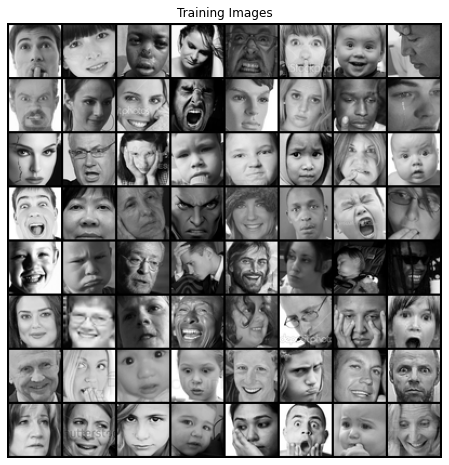

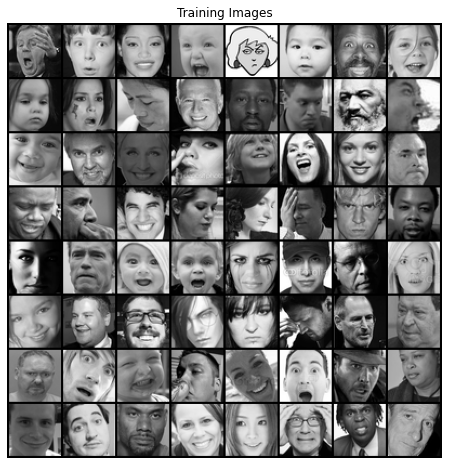

In [4]:
# We can use an image folder dataset the way we have it setup.
# Create the dataset 
train_set = dset.ImageFolder(root=train_dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(IMAGE_SIZE),
                               transforms.CenterCrop(IMAGE_SIZE),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))


test_set = dset.ImageFolder(root=test_dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(IMAGE_SIZE),
                               transforms.CenterCrop(IMAGE_SIZE),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))


# Create the train dataloader
train_dataloader = torch.utils.data.DataLoader(train_set, batch_size=batch_size,
                                         shuffle=True)

# Create the test dataloader
test_dataloader = torch.utils.data.DataLoader(test_set, batch_size=batch_size,
                                         shuffle=True)

class_names = train_set.classes
print(class_names)

# Plot some of the training images
real_batch = next(iter(train_dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

# Plot some of the testing images
real_batch = next(iter(test_dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

print(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)).shape)

In [5]:
# Function for displaying predictions for a few images, in this case 6.
#print(test_set[0])

def visualize_expression_model(model, num_images=4):
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(test_dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                plt.imshow(inputs.cpu().data[j].squeeze().permute(1, 2, 0), cmap="gray")

                if images_so_far == num_images:
                    return

In [6]:
def train_expression_model(model, data, criterion, optimizer):
    since = time.time()
    best_acc = 0.0
    model.train()   # Set model to train mode
    running_loss = 0.0
    running_corrects = 0
    
    for inputs, labels in data:
        inputs = inputs.to(device)
        labels = labels.to(device)
    
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)
        
        # zero the parameter gradients, and use backpropagatation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        
    epoch_loss = running_loss / len(train_dataloader)
    epoch_acc = running_corrects.double() / len(train_dataloader)

    print('train Loss: {:.4f} Acc: {:.4f}'.format(epoch_loss, epoch_acc))

In [7]:
def test_expression_model(model, data, criterion):
    since = time.time()
    best_acc = 0.0
    model.eval()   # Set model to evaluate mode
    running_loss = 0.0
    running_corrects = 0
    
    for inputs, labels in data:
        inputs = inputs.to(device)
        labels = labels.to(device)
    
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)
        
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        
    epoch_loss = running_loss / len(test_dataloader)
    epoch_acc = running_corrects.double() / len(test_dataloader)

    print('test Loss: {:.4f} Acc: {:.4f}'.format(
        epoch_loss, epoch_acc))

In [8]:
# This is a recreation of the AlexNet

class Facial_Expression_Network(nn.Module):
    def __init__(self):
        super(Facial_Expression_Network, self).__init__()

        self.features = nn.Sequential(
            nn.Conv2d(3, IMAGE_SIZE, kernel_size=(3,3), stride=(1, 1), padding=(2, 2)), 
            nn.ReLU(inplace=True), # Rectified Linear Unit activation function
            nn.MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False), # pooling layer for reducing dimensions
            nn.Conv2d(IMAGE_SIZE, 192, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2)),
            nn.ReLU(inplace=True),
            nn.Conv2d(192, 192, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2)),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False),
            nn.Conv2d(192, 384, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
        )

        self.avgpool = nn.AdaptiveAvgPool2d(output_size=(6, 6)) # Applies a 2D adaptive average pooling over an input composed of several input planes.


        self.classifier = nn.Sequential(
            nn.Dropout(p=0.5, inplace=False), # Dropout layer for setting 50% of the activations to 0, fording the network to not rely on any 1 node
            nn.Linear(in_features=9216, out_features=4096, bias=True), # Linear layer
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5, inplace=False),
            nn.Linear(in_features=4096, out_features=4096, bias=True),
            nn.ReLU(inplace=True),
            nn.Linear(in_features=4096, out_features=6, bias=True),
        ) # ---- Change out_features if change in amount of classes ----


        self.softmax = nn.Softmax(dim=1) # last activation function for the network, normalizing the output
        self.softmax_result = 0 

    def forward(self, x, verbose=False):
        x = self.features(x)
        x = self.avgpool(x)

        # The data needs to be flattened after the AdaptiveAvgPool2d as its output is H x W
        # This is because the classifier's first layer is a Linear layer
        x = torch.flatten(x, 1)

        x = self.classifier(x) 
        self.softmax_result = self.softmax(x)
        return x

In [9]:
expression_model = Facial_Expression_Network().to(device)

loss_fn = nn.CrossEntropyLoss()

# optimizer = torch.optim.SGD(expression_model.parameters(), lr=lr, momentum = 0.9) # So far, only 31.1% acc
optimizer = torch.optim.Adam(expression_model.parameters(), lr=lr)

# Decay LR by a factor of 0.1 every 1 epochs
scheduler = lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.1)

In [10]:
for epoch in range(1, (num_epochs+1)):
    print('Epoch {}/{}'.format(epoch, num_epochs))
    print()
    train_expression_model(expression_model, train_dataloader, loss_fn, optimizer)
    test_expression_model(expression_model, test_dataloader, loss_fn)
    #scheduler.step

Epoch 1/20

train Loss: 221.4302 Acc: 32.7783
test Loss: 209.5647 Acc: 37.7321
Epoch 2/20

train Loss: 206.2292 Acc: 41.5566
test Loss: 193.5326 Acc: 46.4286
Epoch 3/20

train Loss: 182.0354 Acc: 54.6606
test Loss: 170.3710 Acc: 59.4643
Epoch 4/20

train Loss: 167.2696 Acc: 60.8235
test Loss: 156.2138 Acc: 64.5179
Epoch 5/20

train Loss: 156.4370 Acc: 66.0588
test Loss: 151.8758 Acc: 66.2500
Epoch 6/20

train Loss: 150.4442 Acc: 68.5701
test Loss: 146.8125 Acc: 69.2321
Epoch 7/20

train Loss: 143.7240 Acc: 71.5385
test Loss: 144.2556 Acc: 70.0714
Epoch 8/20

train Loss: 138.9549 Acc: 73.6606
test Loss: 140.9477 Acc: 70.2321
Epoch 9/20

train Loss: 135.1564 Acc: 75.1629
test Loss: 140.4197 Acc: 71.5357
Epoch 10/20

train Loss: 131.4222 Acc: 76.9593
test Loss: 135.4128 Acc: 73.5357
Epoch 11/20

train Loss: 126.0368 Acc: 79.0090
test Loss: 136.5997 Acc: 73.8929
Epoch 12/20

train Loss: 122.9239 Acc: 80.5928
test Loss: 136.7790 Acc: 73.4107
Epoch 13/20

train Loss: 118.9540 Acc: 82.1131
te

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


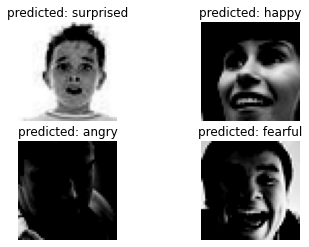

In [11]:
visualize_expression_model(expression_model)